<h1>Linearization Tools </h1>

<font size="3">

<hr>
DISTRIBUTION STATEMENT A. Approved for public release. Distribution is unlimited.

This material is based upon work supported by the Under Secretary of Defense for
Research and Engineering under Air Force Contract No. FA8702-15-D-0001. Any opinions,
findings, conclusions or recommendations expressed in this material are those of the
author(s) and do not necessarily reflect the views of the Under Secretary of Defense
for Research and Engineering.

© 2023 Massachusetts Institute of Technology.

The software/firmware is provided to you on an As-Is basis

Delivered to the U.S. Government with Unlimited Rights, as defined in DFARS Part
252.227-7013 or 7014 (Feb 2014). Notwithstanding any copyright notice, U.S. Government
rights in this work are defined by DFARS 252.227-7013 or DFARS 252.227-7014 as detailed
above. Use of this work other than as specifically authorized by the U.S. Government
may violate any copyrights that exist in this work.
<hr><hr>
</font>

<h3><b><u>1. Introduction</u></b></h3>

This notebook provides routines for solution of nonlinear ordinary differential equations using Carleman linearization.  More specifically, these methods linearize a collection of $\ell$ nonlinear differential equations, which thsemselves comprise a  $K$-th order polynomial ODE:

\begin{align} 
d_t (u) & = \sum_{k=0}^K F_k(u^{\otimes k})\\
&= F_0(t) + F_1(u) + F_2(u^{\otimes 2}) + \dots + F_{K}(u^{\otimes K}) 
\end{align}

Here we use  $u = [u_1(t), u_2(t), \dots, u_\ell(t)]^T$ to denote a vector of parametric functions $u:D \longrightarrow \mathbb{R}$ that are $r$-fold differentiable (e.g., of the class $C^r$). These equations are defined on a domain $D \subset \mathbb{R}$ that is large enough to capture the dynamics of interest.  We  also consider an inhomogeneous term $F_0(t) = [f_1(t), f_2(t), \dots, f_\ell(t)]^T$ which may contain constants or (at least) $C^1$ parametric function.   The delivered linear system can be integrated using any conventional method.  We provide a forward Euler scheme for reference, since it is most relevant for applications using quantum ODE/PDE solvers.

OUr discussion uses conventional multilinear algebra to simplify notation. Unless otherwise specified, $F_k$ is used to denote $1$-contravariant, $k$-covariant  tensors $F_k \in V \otimes (V^*)^{\otimes k}$, which define a linear transform $F_k: V^{\otimes k} \longrightarrow V$ of $u^{\otimes k}$ by the coefficient set for the ODE.  Here we write $V$ and $V^*$ for a vector space and its dual (respectively), use $u^{\otimes k} \in V^{\otimes k}$ to denote the $k$--fold tensor product, and write $\mathbf{1}:V\longrightarrow V$ for the identity tensor when applicable. 

<h4><u>Carleman Procedure</u></h4>

<b>Introduction: Quadratic Case</b>


 We will use the quadratic variant ($K = 2$) of Eq.~\ref{eq:tensor_system_intro} as both an example and a means to solidify our conventions.  This case is particularly notable, as any nonlinear polynomial system may be reduced to a quadratic counterpart (as we demonstrate later). For pedagogical simplicity, we will deviate from our $F_k$ notation and write $A_1 = F_1$ for the coefficients of $u$ and $B_1 = F_2$ for the coefficients of $u^{\otimes 2} = u \otimes u$.  We may then write,


\begin{equation} 
\frac{du}{dt} = A_1(u) + B_1(u\otimes u) + \mathbf{1} \cdot F_0(t).
\end{equation}


 We will later adopt the notation $C_1$ for the inhomogeneous term. Following this arrangement, the coefficient sets $A_1$ and $B_1$ act through first order (matrix multiplication) and second--order tensor contraction, respectively:

\begin{align}
(A_1(u))_i &= \sum_j (A_1)_{ij} u_j, \\
(B_1(u \otimes u))_i &= \sum_{jk} (B_1)_{ijk} u_j u_k.
\end{align}


The nonlinearity in Eq. , comes from the $B_1(u\otimes u)$ term.  Carleman embedding  linearizes this contribution by promoting  individual components of the tensor $u_{i,j} = u_i u_j = (u\otimes u)_{ij} $  to auxiliary variables with their own ODE system.  We can construct these equations  using the differential operator $d_t = d/dt$, which acts multilinearly over the tensor product,

 
\begin{equation}
d_t ( u^{\otimes 2})  = d_t(u\otimes u) = u\otimes d_t(u) + d_t(u)\otimes u,
\end{equation} 
 
and through substitution from Eq., 
 
\begin{split}
d_t(u) &= \big[ A \otimes I + I \otimes A\big](u^{\otimes 2}) + \big[ B \otimes I + I \otimes B\big] (u^{\otimes 3}) \, + \, \big[(\mathbf{1} \cdot f_0) \otimes I + I \otimes (\mathbf{1} \cdot f_0)\big] (u)  \\
&=  A_2(u^{\otimes 2}) + B_2(u^{\otimes 3}) + C_2(u).
\end{split}

This expression can be combined with Eq. to give a matrix valued relation,

\begin{equation} 
\frac{d}{dt}\begin{pmatrix}u\\u^{\otimes 2}\end{pmatrix} = \left[ \begin{pmatrix}A_1 & B_1 \\ C_2 & A_2 \end{pmatrix} + \begin{pmatrix}C_1\\0 \end{pmatrix} \right]\begin{pmatrix}u\\u^{\otimes 2}\end{pmatrix} + B_2(u^{\otimes 3}).
\end{equation}


We see that the nonlinearity has shifted to the $u^{\otimes 3}$ term.  While overall system remains nonlinear, this is now implicit for the equation of motion in $u^{\otimes 2}$.  The nonlinear contributions can be pushed to  yet order by repeating the procedure and introducing new variables $u_{i,j,k} = (u^{\otimes 3})_{ijk}$ so that:


\begin{equation}
\begin{split}
d_t ( u^{\otimes 3})  &=  d_t(u) \otimes u^{\otimes 2} + u \otimes d_t(u) \otimes u + u^{\otimes 2} \otimes d_t(u) \\ 
& =  A_3(u^{\otimes 3}) + B_3(u^{\otimes 4}) + C_3 \, u^{\otimes 2}
\end{split}
\end{equation}

where we have defined the coefficient tensors in an analogous manner:


\begin{align}
A_3 &=   A_1 \otimes I^{\otimes 2} + I \otimes A_1 \otimes I + I^{\otimes 2} \otimes A_1, \\
B_3 &=   B_1 \otimes I^{\otimes 2} + I \otimes B_1 \otimes I + I^{\otimes 2} \otimes B_1, \\ 
C_3 &=   C_1 \otimes I^{\otimes 2} + I \otimes C_1 \otimes I + I^{\otimes 2} \otimes C_1. 
\end{align}

If we again write this as a matrix system (following Eq.~\ref{eq:matrix_system_order_2}), we see an emergent  tridiagonal structure,


\begin{equation}
\frac{d}{dt}\begin{pmatrix}u\\u^{\otimes 2}\\ u^{\otimes 3}\end{pmatrix} = \left[ \underbrace{\begin{pmatrix}A_1 & B_1 & 0 \\ C_2 & A_2 & B_2  \\
0 & C_3 & A_3 \end{pmatrix}}_{\text{Tridiagonal}} + \begin{pmatrix}C_1\\0\\0 \end{pmatrix} \right]\begin{pmatrix}u\\u^{\otimes 2}\\ u^{\otimes 3} \end{pmatrix} + B_3(u^{\otimes 4}).
\end{equation}




<b>General Linerization Procedures</b>


We can now address linearization for polynomial systems of arbitrary order.   Our starting point is now the $K$--th order system:

\begin{align} 
d_t (u) & = \sum_{k=0}^K F_k(u^{\otimes k})\\
&= F_0(t) + F_1(u) + F_2(u^{\otimes 2}) + \dots + F_{K}(u^{\otimes K}).
\end{align}

The general linearization procedure follows from the quadratic case, where we inductively shifted nonlinearity in the $n$--th order equations $y_n = u^{\otimes n}$ to their $(n+1)$--th order successors.  The higher--order differential system  follows from the parametric derivative $d_t (y_n)$, which may be expressed by using linearity of the differential operator over the tensor product:


\begin{split}
d_t(y_n)  & = \sum_{\nu=0}^{n-1} u^{\otimes \nu} \otimes d_t (u) \otimes u^{\otimes n-\nu-1} \\
&= d_t(u) \otimes u^{\otimes (n-1)} + u \otimes d_t(u) \otimes u^{\otimes (n-2)} + \dots + u^{\otimes (n-1)} \otimes d_t(u).
\end{split}

We can likewise write the $k$--th order differential equations for $y_n$ in terms of a general and  compact notation,

\begin{split}
A_{n+k-1}^n & = \sum_{\nu=0}^{n-1} I^{\otimes \nu} \otimes F_k \otimes I^{\otimes (n-\nu-1)} \\
&= F_k \otimes I^{\otimes (n-1)} + I \otimes F_k \otimes I^{\otimes (n-2)} + \dots + I^{\otimes (n-1)} \otimes F_k.
\end{split}

Putting these components together, we substitute the  system from  Eq.~\ref{eq:tensor_system_general} into each term in our expression for $d_t (y_n)$ to give:

\begin{split} 
d_t(y_n) & = \sum_{\nu=0}^{n-1} u^{\otimes \nu} \otimes \left[ \sum_{k=0}^K F_k(u^{\otimes k}) \right] \otimes u^{\otimes (n-\nu-1)} \\
& = \sum_{k=0}^K \sum_{\nu=0}^{n-1} u^{\otimes \nu} \otimes F_k(u^{\otimes k}) \otimes u^{\otimes (n-\nu-1)} \\
& = \sum_{k=0}^K \sum_{\nu=0}^{n-1} \left[I^{\otimes \nu} \otimes F_k \otimes I^{\otimes (n-\nu-1)} \right] \left[ u^{\otimes \nu} \otimes u^{\otimes k} \otimes u^{\otimes (n-\nu-1)} \right] \\
& = \sum_{k=0}^K \sum_{\nu=0}^{n-1} \left[I^{\otimes \nu} \otimes F_k \otimes I^{\otimes (n-\nu-1)} \right] u^{\otimes (n+k-1)} \\
& = \sum_{k=0}^K A_{n+k-1}^n u^{\otimes (n+k-1)}
\end{split}

 Here we  changed the order of summation in the second line and noted that each factor in the tensor product $u^{\otimes k}$ is identical in order to derive the third lien.  In doing so, we define an infinite hierarchy of differential equations, where nonlinearity from the $(n+1)$--th order term in the  system for $y_n$ is lifted by the expanded parametric system in $y_{n+1}$.  This can be summarized by a set of matrix equations,

 \begin{equation}
d_t(\hat{y}) = \mathcal{A} \cdot \hat{y} + \mathcal{A}_0,
\end{equation}

where we have use the notation $\hat{y} = [y_1, y_2, y_3, \dots]^T$ for the infinite system.  The quantity $\hat{y}$ corresponds to an infinite--dimensional column vector if we represent the tensor product $u^{\otimes k}$ as a Kronecker product of $u = [u_1, u_2, \dots, u_\ell]^T$).  Similarly, the coefficients $\mathcal{A}$ may be treated as a  $(K+1)$--diagonal matrix, with comparable notation  for the inhomogeneous term $\mathcal{A}_0$:

\begin{align}
\mathcal{A} = \begin{pmatrix}
   A^1_1  &  A^1_2  &  A^1_3  & \dots &  A^1_K  &      0      &      0      &  \dots \\
   A^2_1  &  A^2_2  &  A^2_3  & \dots &  A^2_K  &  A^2_{K+1}  &      0      &  \dots \\
     0    &  A^3_2  &  A^3_3  & \dots &  A^3_K  &  A^3_{K+1}  &  A^3_{K+2}  &  \dots \\
   \vdots &  \vdots &  \vdots &       &  \vdots &  \vdots     &   \vdots    &        
\end{pmatrix}, & & \mathcal{A}_0 = \begin{pmatrix} A_0^1 \\ 0 \\ 0 \\ \vdots \end{pmatrix}.
\end{align}




In a practical calculation, we truncate this system after $y_N$ and discard its $(N+1)$-th order nonlinearity. 


<h4><u>Reduction to a Quadratic System</u></h4>

The framework developed for linearization also allows us to write $K$--th order ODEs as a quadratic system of equations.  We again consider a system,

\begin{equation} 
 d_t (u) = F_0(t) + F_1(u) + F_2(u^{\otimes 2}) + \dots + F_{K}(u^{\otimes K}),
\end{equation}

 and introduce the notation $ x_n = u^{n} $ to distinguish our procedure here from the full linearization scheme.  We previously showed that,

\begin{equation}
d_t(x_n) = \sum_{k=0}^K A_{n+k-1}^n (x_{n+k-1}),
\end{equation}

which is just a restatement of Eq.~\ref{eq:eq:tensor_system_general_linearderiv_n} in terms of the functions $x_n(t)$.  To facilitate this reduction, we now linearize the system in Eq.  to order $(K-1)$ while explicitly tracking the leading factors of $x_{K-1}$.  Doing so (and setting aside the $A^{1}_0$ term for now) we see that,

\begin{split}
d_t(x_1)  =& A^{1}_1\, (x_1) + A^{1}_2 \,(x_2) + \dots + A^1_{K-1}\, (x_{K-1}) + A^1_K \, (x_1 \otimes x_{K-1}) \\
d_t(x_2)  =& A^{2}_1\, (x_1) + A^{2}_2 \,(x_2) + \dots + A^2_{K-1}\, (x_{K-1}) + A^2_K \, (x_1 \otimes x_{K-1}) + A^2_{K+1} \, (x_2 \otimes x_{K-1}) \\
 &  \hspace{150pt} \vdots \\
d_t(x_{K-1}) =& A^{K-1}_{K-2}\, (x_{K-2}) + A^{K-1}_{K-1} \, (x_{K-1}) + \dots + A^{K-1}_{K-1}\, (x_{K-1}) + A^{K-1}_K \, (x_1 \otimes x_{K-1})  + \dots  \\
& + A^{K-1}_{2(K-1)} \, (x_{K-1} \otimes x_{K-1} ),
\end{split}

 which reveals one set of terms with a single factor of $\hat{x} = [x_1, x_2, \dots, x_{K-1}]$ and set containing  $\hat{x}\otimes\hat{x}$.  This suggests a new quadratic differential system,

\begin{equation}
d_t(\hat{x}) = \tilde{F}_1 (\hat{x}) + \tilde{F}_2 (\hat{x}\otimes \hat{x}) + \tilde{F}_0(t),
\end{equation}

\noindent provided that we define,

\begin{align}
\tilde{F}_1 = \begin{pmatrix}
   A^1_1  &  A^1_2  &  A^1_3  &  A^1_4 & \dots &  A^1_{K-1}   \\
   A^2_1  &  A^2_2  &  A^2_3  &  A^2_4 & \dots &  A^2_{K-1}   \\
     0    &  A^3_2  &  A^3_3  &  A^3_4 & \dots &  A^3_{K-1}   \\
     0    &    0    &  A^4_3  &  A^4_4 & \dots &  A^4_{K-1}   \\
     0    &    0    &    0    &  \ddots& \ddots &  \vdots     \\
     0    &    0    &    0    &  \dots & A^{K-1}_{K-2}  &   A^{K-1}_{K-2}   \\        
\end{pmatrix}, & & \tilde{F}_0 = \begin{pmatrix} A_0^1 \\ 0 \\ 0 \\ \vdots \\ 0\\  0\end{pmatrix}
\end{align}



and,

\begin{align}
\tilde{F}_2 = \left(\begin{array}{ccccccccccccc} 
   0   & \dots &    0   & A^1_K     & 0      & \dots &    0   & 0             &    0   & \dots & 0  & 0 \\
   0   & \dots &    0   & A^2_K     & 0      & \dots &    0   & A^2_{K+1}     &    0   & \dots & 0  & 0 \\
\vdots &       & \vdots & \vdots    & \vdots &       & \vdots & \vdots        & \vdots &       & \vdots & \vdots \\
   0   & \dots &    0   & A^{K-1}_K & 0      & \dots&    0   & A^{K-1}_{K+1} &    0   & \dots  & 0 & A^{K-1}_{2(K - 1)}\\
\end{array}\right).
\end{align}

<hr>
<h3><u><b>2. Numerical Examples</b></u></h3>


In [2]:
import  numpy                as  np
import  scipy.sparse         as  sps
import  scipy.integrate      as  spi
import  matplotlib.pyplot    as  plt

import  multilinear_algebra  as  mla

import  linearization_tools  as  ltools
import  vlasov_spectral      as  vs
import  burgers_nonlinear    as  nlin

def pprint_matrix(mat):
    
    for row in mat:
        for item in row:
            print(f"{item:.2}","\t",end="")
        print()


<h4><u>Example: Input Specification</u></h4>

<b>Parameter Domain</b>

Our ODE system is specified in terms of a single parameter $t \in D = [0,T]$.  We discretize this domain into  $N_\text{step} = \lceil T / \delta t\rceil +1 $ evenly spaced points $t_n = n\cdot \delta t$ with $n \in \{0,\dots,N-1\}$. The step $\delta t$ defines the resolution of our discretization.

In [3]:

dt  =  0.001                        #  Timestep
T   =  40.0                         #  Maximal time

N_step = int(np.ceil(T/dt)) + 1     #  Number of timesteps

b   = 0.0                       

xpts  = np.linspace(0.0,T,num=N_step)


<b>Set up ODE System</b>

We demonstrate our input specification for a single-parameter first-order ODE system:

\begin{align}
\dot{u}_1(t) &= u_1 + u_1^2 + u_1 u_2 - 2 u_1^3\\
\dot{u}_2(t) &= u_1 - 2 u_2 - 3 u_1 u_2 - 2 u_2^2 + 3 u_2^3
\end{align}

where $u_i :D \longrightarrow \mathbb{R}$ are the constituent functions and $\dot{u} = d_t u$ denotes the parameteric derivative.  This system is passed to  our linearization routines according to a more compact notation:

\begin{align} 
d_t (u) = F_0(t) + F_1(u) + F_2(u^{\otimes 2}) + F_3(u^{\otimes 3}) 
\end{align}

where  $u = [u_1(t), u_2(t)]^T$ is a vector and $u^{\otimes n}$ denotes its $n$-fold tensor product (e.g., $u^{\otimes 2} = [u_1^2, u_1 u_2, u_2 u_1, u_2^2]$).  The $F_i$ are coefficient tensors which have been reshaped into $2 \times 2^n$ matrices.  Using the system above as an example:

\begin{align}
F_1 & = \begin{bmatrix} 1 & 0 \\ 1 & -2\end{bmatrix} \\
u & =  \begin{bmatrix}u_1 & u_2\end{bmatrix}^T 
\end{align} 



\begin{align}
F_2 & = \begin{bmatrix} 1 & 1 & 0 & 0 \\ 0 & 0 & -3 & -2\end{bmatrix} \\
u^{\otimes 2} & =  \begin{bmatrix}u_1^2 & u_1 u_2 & u_2 u_1 & u_2^2 \end{bmatrix}^T \\
\end{align}


\begin{align}
F_3 & = \begin{bmatrix} -2 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\  0 & 0 & 0 & 0 & 0 & 0 & 0 & 3\end{bmatrix} \\
u_3 & =  \begin{bmatrix}u_1^3 & u_1^2 u_2 & u_2 u_1^2 & u_2^2 u_1 & u_1^2 u_2 & u_1 u_2^2 & u_2^2 u_1 & u_2^3 \end{bmatrix}^T 
\end{align}

Of course, this means that the $F_i$ are not unique $-$ there are multiple ways to pass coefficients for terms that are repeated in $u^{\otimes n}$.  Splitting these coefficients across multiple entries will, however, reduce sparsity of the system.

In [4]:
F_1 = np.array([[ 1.0,  0.0 ], 
                [ 1.0,  -0.2 ]]);

F_2 = np.array([[ 1.0,  1.0,  0.0,  0.0  ],
                [ 0.0,  0.5, -3.0, -2.0  ]]);

F_3 = np.array([[ -2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0 ],
                [  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0 ]]);

coeff_set  =  [F_1, F_2, F_3]



<hr>
<h4><u>Example: Van der Pol Oscillator</u></h4>

The canonical, two-dimensional form of the Van der Pol oscillator is:

\begin{align}
\dot{u}_1 & = \mu \Big(u_1 - \frac{u_1^3}{3} \Big) + u_2 \\
\dot{u}_2 & = -u_1
\end{align}

where the damping parameter $\mu \in \mathbb{R}$ controls the degree of nonlinearity.  A conventional harmonic oscillator is recovered when $\mu = 0$, while $\mu > 0$ results in nonconservative systems that approach a global limit cycle.  This the latter occurs with distinctive and paramter-specific 'relaxation oscillations.' The Van der Pol oscillator is somewhat ubiquitous, appearing in systems that span from electrical circuits to electrical oscillations in neurons.

We define this system as follows:

In [5]:
mu   =  0.1                         # nonlinear damping parameter
u_0  =  np.array([1.0,0.0])         # initial conditions

F_1 = np.array([[ mu,  1.0 ], 
                [ -1.0,  0.0 ]]);

F_3 = np.array([[ -mu/3, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,  0.0 ],
                [  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,  0.0 ]]);

coeff_set  =  [F_1, F_3]


We now perform linearization and compare with a classical solution.  Linearization is handled by the `Linearizer` class, which is initialized as follows (using `sparse=True` to specify sparse matrix routines):

In [6]:
N_lin  =  4             # linearization order

LL = ltools.Linearizer(coeff_set,sparse=True)

Run the Carleman linearization procedure to order `N_lin` using the `carleman()` method.  Also set up the epanded initial value problem using `ivp()`:

In [7]:
LL.carleman(N_lin)          # Build the linearization
LL.ivp(u_0)                 # Build the IVP data

Obtain items of interest from the class:

In [8]:

A    =  LL.op()              # grab the linear evolution matrix
A_s  =  LL.op_s()            # grab the linear evolution matrix in a sparse representation
iv   =  LL.iv()              # grab the initial value vector

We can query properties of the sparse system:

In [9]:
A_s

<126x126 sparse matrix of type '<class 'numpy.float64'>'
	with 805 stored elements in COOrdinate format>

Or get a copy of the sparse system as a list.  Here nonzero elements of the linearized system are given by as `((row,col), value)`:

In [10]:
A_s_list = LL.op_s_data()

A_s_list[1:10]

[((0, 1), 1.0),
 ((1, 0), -1.0),
 ((1, 1), 0.0),
 ((0, 6), -0.03333333333333333),
 ((2, 2), 0.2),
 ((2, 3), 1.0),
 ((3, 2), -1.0),
 ((3, 3), 0.1),
 ((2, 4), 1.0)]

We can now integrate the nonlinear system using standard routines like LSODA:

In [11]:
traj_raw_cm = spi.odeint(ltools.prop_nonlinear,u_0,xpts,args=(coeff_set,),atol=1.0e-16)

And compare with a foward Euler integration of the linearized system:

In [12]:
u_sol = ltools.euler_int_fw(A,iv,dt,T)

Total number of linear ODEs from Carleman procedure:

In [13]:
iv.shape[-1]

126

Plot the nonlinear and linaerized Carleman results side-by-side:

Text(0, 0.5, 'Oscillator Amplitude')

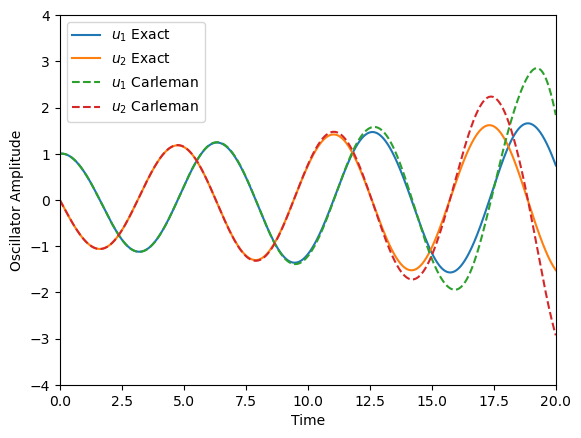

In [14]:
xpts  = np.linspace(0.0,T,num=N_step)
timestep_vec = np.arange(0,T,dt)  

plt.plot(xpts,traj_raw_cm[:,0])
plt.plot(xpts,traj_raw_cm[:,1])

plt.plot(timestep_vec,u_sol[0,:],"--")
plt.plot(timestep_vec,u_sol[1,:],"--")

plt.xlim([0.0,  20.0])
plt.ylim([-4.0, 4.0])

plt.legend(['$u_1$ Exact','$u_2$ Exact','$u_1$ Carleman','$u_2$ Carleman'])
plt.xlabel('Time')
plt.ylabel('Oscillator Amplitude')

The linearization works pretty well for a time, at least until the nonlinearity leads to significant drift.  Increasing the order of linearization `N_lin` extends this regime at the expense of a much larger system.  Clearly this system isn't a good candidate for linearization $-$ it is much more taxing than the damped problems with better convergence characteristics.

<hr>
<h4><u>Example: Lotka-Volterra System ("Predator-Prey" model)</u></h4>

The Lotka-Volterra system is defined as:

\begin{align}
\dot{u}_1 &= \alpha_1 u_1 - \delta_1 \, u_1 u_2 \\
\dot{u}_2 &= -\alpha_2 u_2 + \delta_2 \, u_1 u_2 
\end{align}

where $\alpha_i, \delta_i \in \mathbb{R}^+$. This model can be used to describe the population of two different species in competition (assuming, e.g., that they prey are not food-limited).  This model is more difficult to treat with Carleman linearization since the interesting paramter regimes are generally quite nonlinear.

We again set up the problem:

In [15]:
c1  =  0.4;    c2  =  1.0;    
d1  =  0.01;    d2  =  0.02;


u_0  =  np.array([ 20, 10 ])         # initial conditions

F_1 = np.array([[ c1,   0.0 ], 
                [ 0.0,  -c2 ]]);

F_2 = np.array([[ 0.0,  -d1,  0.0,  0.0 ],
                [ 0.0,  0.0,   d2,  0.0 ]]);

coeff_set  =  [F_1, F_2]

Compute an 'exact' result for the full nonlinear system:

In [16]:
traj_raw_cm = spi.odeint(ltools.prop_nonlinear,u_0,xpts,args=(coeff_set,),atol=1.0e-16)

Perform the linearization procedure:

In [17]:
N_lin  =  8            # linearization order

LL = ltools.Linearizer(coeff_set,sparse=True)

LL.carleman(N_lin)          # Build the linearization
LL.ivp(u_0)                 # Build the IVP data

A   =  LL.op()              # grab the linear evolution matrix
iv  =  LL.iv()              # grab the initial value vector


And integrate the linearized system:

In [18]:
u_sol = ltools.euler_int_fw(A,iv,dt,T)

The linear system has this many distinct equations:

In [19]:
iv.shape[-1]

1022

The Lotka-Volterra system has a more pronounced nonlinearity than the Van der Pol oscillator.Linearization fails even more dramatically:

Text(0, 0.5, 'Population ')

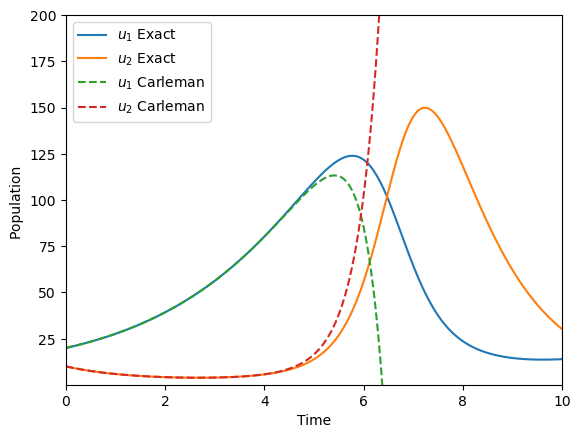

In [24]:
xpts  = np.linspace(0.0,T,num=N_step)
timestep_vec = np.arange(0,T,dt)  

plt.plot(xpts,traj_raw_cm[:,0])
plt.plot(xpts,traj_raw_cm[:,1])

plt.plot(timestep_vec,u_sol[0,:],"--")
plt.plot(timestep_vec,u_sol[1,:],"--")

plt.xlim([0.0,  10.0])
plt.ylim([0.1, 200.0])

plt.legend(['$u_1$ Exact','$u_2$ Exact','$u_1$ Carleman','$u_2$ Carleman'])
plt.xlabel('Time')
plt.ylabel('Population ')

<hr>
<h4><u>Viscous Burgers Equation</u></h4>

The Navier-Stokes equation describes a fluid that is subject to both driving and damping forces:

\begin{equation}
\partial_t \mathbf{u} + (\mathbf{u} \cdot \nabla)\mathbf{u} + \beta \mathbf{u} = \nu \nabla^2 \mathbf{u} + \mathbf{F}
\end{equation}

A simpler limit is the viscous Burger's equation, which takes a simple form for 1d fluids:

\begin{equation}
\partial_t u + u \,\partial_x u  = \nu \partial_x^2 u + F
\end{equation}

This reduces to a set of coupled ODEs when we discretize the spatial domain and use a finite difference scheme.



In [25]:
N      =   16       # Number of spatial points
L      =  1.0       # Length of spatial domain
gamma  =  0.0       # Damping parameter

Reynolds   =  20                   # Target Reyolds number for flow
vmax       =  1.0/np.sqrt(N-1)     # Maximum velocity w/ drive or initial condition

nu         =  vmax*L/Reynolds      # Dynamic viscosity

nk = 1.0                           # 

coeff_set = nlin.vbe_system(L,N,nu,gamma=gamma)

In [26]:
N_lin  =  4            # linearization order

LL = ltools.Linearizer(coeff_set,sparse=True)

LL.carleman(N_lin)          # Build the linearization
#LL.ivp(u_0)                 # Build the IVP data

A   =  LL.op()              # grab the linear evolution matrix
#iv  =  LL.iv()              # grab the initial value vector


Properties of the sparse system:

In [27]:
A_sparse = LL.op_s()
A_sparse

<1118480x1118480 sparse matrix of type '<class 'numpy.float64'>'
	with 11255818 stored elements in COOrdinate format>

<hr>
<h4><u>Vlasov Equation: Fourier-Hermite Representation</u></h4>

This problem follows from a dual-spectral representation of the Vlasov-Poisson equation, which has a long legacy:

<ol>
<li>F. C. Grant, M. R. Feix, "Fourier-Hermite Solutions of the Vlasov Equations in a Linearized Limit"  Phys. Fluids., <b>10</b>, 696 (1967).</li>
<li>J. T. Parker and P. J. Dellar, "Fourier-Hermite spectral representation for the Vlasov-Poisson system in the weakly collisional limit"  J. Plasma Phys., <b>81</b>, 1 (2015).</li>
<li>J. K. Kormann and A. Yurova, "A generalized Fourier-Hermite method for the Vlasov-Poissson system"  BIT Num. Math., <b>61</b>, 881 (2021).</li>
</ol>

We follow [3] and recap notation below.

The Vlasov equation captures the kinetics of charged particles interacting with a self-consistely determined electric field (such as a plasma).  This scheme be extended to include collisional dynamics, multiple species, etc., though we will focus on a single-species system in one spatial dimension (e.g., on the interval $[0,L] \subset \mathbb{R}$).  Assuming a charge-neutralizing background, the particle distribution function $f(x,v,t)$ will take the form:

\begin{equation}
\dot{f}(x,v,t) + v\,\partial_x f(x,v,t) - E(x,t) \,\partial_v f(x,v,t) = 0
\end{equation}

Here $E(x,t)$ denotes the electric field strength.  We use $x$ to denote the spatial position $x \in [0,L]$, write $v \in \mathbb{R}$ for the velocity, and let $t \in \mathbb{R}$ be our time parameter.  The electric field is obtained by solving the Poisson equation:

\begin{equation}
\dot{E}(x,t) = 1 - \int f(x,v,t) \, dv 
\end{equation}


There are a variety of schemes to solve this system.  We consider the case where the distribution function $f(x,v,t)$ is handled through a <i>dual spectral expansion.</i>  This follows from an expansion of the spatial components in a Fourier basis and the velocity components in a basis of generalied Hermite functions:

\begin{equation}
f(x,v,t) = \sum_{k=-N_x}^{N_x} \sum_{ell=0}^{N_v-1} c_\ell^k \, H_\ell^{\gamma,\epsilon} (v) e^{2\pi \imath k x/L} 
\end{equation}


where $N_x$ and $N_v$ are the number of points in the (Galerkin) spatial and velocity discretizations, respectively.  This introduces two new parameters $\gamma,\epsilon$ which control the discretization (see Kormann and Yurova, 2021).

The equation of motion for coefficients is:
    
\begin{equation}
\dot{c}_\ell^k (t) = -\frac{1}{\gamma \epsilon \sqrt{2}}\frac{2\pi k \imath}{L} \left(\sqrt{\ell+1} \,c_{\ell+1}^k(t) + \sqrt{\ell} \,c_{\ell-1}^k(t)\right) + \frac{\epsilon \sqrt{2}}{\gamma} \left((\gamma^2-1) \sqrt{\ell + 1}\,[\mathbf{E}(t) * \mathbf{c}_{\ell+1}(t) ][k]  - \sqrt{\ell}\,[\mathbf{E}(t) * \mathbf{c}_{\ell-1}(t) ][k]  \right)
\end{equation}

where  the star notation is used to denote a convolution:


\begin{equation}
[\mathbf{E}(t) * \mathbf{c}_{\ell+1}(t) ][k] = \sum_{j=-N_x}^{N_x} E_{k-j} \, c_\ell^j(t).
\end{equation}


Here, $\mathbf{E}(t)$ is a coefficient vector with components indexed by $k \in [-N_x,\dots,N_x] \subset \mathbb{Z}$.  We use mildly abusive notation and take this to be zero for all other values of $k$.  The coefficient vector $\mathbf{c}(t)$ as components $c_\ell^k(t)$ and is defined similarly.

 The electric field components are also introduced through a spectral (Fourier) representation:

\begin{equation}
E_k(t) = \frac{iL}{2\pi k} \sum_{\ell = 0}^{N_v - 1} c_\ell^k(t) I_\ell
\end{equation}

where we require that $E_0(t) = 0$.  The $I_\ell$ can be defined using a closed-form expression.  However, it is more numerically stable to determine them recursively:

\begin{equation}
I_{\ell+2} = \sqrt{\frac{\ell+1}{\ell+2}} \left(\gamma^2-1\right)I_\ell
\end{equation}

The example below gives a numerical linearization.  We use `N_x = 4` and `N_v = 4` for speed, though reasonable toy example might use `N_x = 32` (65 spatial model) and `N_v = 64`.  Calculations with utility would be larger (say `N_x = 1024` or more) along each spatial dimensions and would be done in 2d or 3d.

In [28]:
 
N_x       =  4         # Spatial discretization points
N_v       =  4         # Velocity discretization points

L_x      =  1.0         # Length of spatial domain

gamma    =  1.3         # Expansion parameters
epsilon  =  1.0

dt  = 0.001;      T   = 1.0;        # Maximum time and timestep

Nstep = int(np.ceil(T/dt))          # Number of points in spatial domain

The vlasov system has first and second order coefficient matrices, which we obtain via `vlasov_spectral_system`.  We can use the keyword `sparse` to get a sparse matrix representation, if desired.

In [29]:
coeff_set =  vs.vlasov_spectral_system(N_x,N_v,L_x,epsilon,gamma,sparse=True)

In [30]:
coeff_set[0]

<36x36 sparse matrix of type '<class 'numpy.float64'>'
	with 48 stored elements in COOrdinate format>

We can convert to ordered pairs for the entries and pair them with the data: 

In [31]:
F_1_pairs = list(zip(zip(coeff_set[0].row, coeff_set[0].col),coeff_set[0].data))
F_1_pairs

[((0, 1), -13.67040904048728),
 ((1, 0), -13.67040904048728),
 ((1, 2), -19.332877868244882),
 ((2, 1), -19.332877868244882),
 ((2, 3), -23.677843018372872),
 ((3, 2), -23.677843018372872),
 ((4, 5), -10.25280678036546),
 ((5, 4), -10.25280678036546),
 ((5, 6), -14.499658401183662),
 ((6, 5), -14.499658401183662),
 ((6, 7), -17.758382263779655),
 ((7, 6), -17.758382263779655),
 ((8, 9), -6.83520452024364),
 ((9, 8), -6.83520452024364),
 ((9, 10), -9.666438934122441),
 ((10, 9), -9.666438934122441),
 ((10, 11), -11.838921509186436),
 ((11, 10), -11.838921509186436),
 ((12, 13), -3.41760226012182),
 ((13, 12), -3.41760226012182),
 ((13, 14), -4.8332194670612205),
 ((14, 13), -4.8332194670612205),
 ((14, 15), -5.919460754593218),
 ((15, 14), -5.919460754593218),
 ((20, 21), 3.41760226012182),
 ((21, 20), 3.41760226012182),
 ((21, 22), 4.8332194670612205),
 ((22, 21), 4.8332194670612205),
 ((22, 23), 5.919460754593218),
 ((23, 22), 5.919460754593218),
 ((24, 25), 6.83520452024364),
 ((25, 

In [32]:
coeff_set[1]

<36x1296 sparse matrix of type '<class 'numpy.complex128'>'
	with 864 stored elements in COOrdinate format>

Linearization follows much like the earlier cases:

In [33]:
N_lin  =  3                 # linearization order

LL = ltools.Linearizer(coeff_set,sparse=True)

LL.carleman(N_lin)          # Build the linearization
#LL.ivp(u_0)                # Build the IVP data

A_s   =  LL.op_s()          # grab the linear evolution matrix
#iv  =  LL.iv()             # grab the initial value vector


In [34]:
A_s

<1727604x1727604 sparse matrix of type '<class 'numpy.complex128'>'
	with 12570384 stored elements in COOrdinate format>

In [35]:
# uncomment below for non-sparse
# A  =  LL.op()          # grab the linear evolution matrix
